
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [12]:
#ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- データファイルのパスを指定 ---
# 収入データ
income_file = 'Data/income_district.csv'
# 国勢調査データ
census_files = [
    'Data/h27_age_df.csv',
    'Data/h27_family_df.csv',
    'Data/h27_gender_df2.csv',
    'Data/h27_house_df.csv',
    'Data/h27_house_info_df.csv',
    'Data/h27_indusry_df.csv',
    'Data/h27_job_df.csv',
    'Data/h27_labor_df.csv',
    'Data/h27_marriage_df.csv',
    'Data/h27_work_status_df.csv'
]

# --- データの読み込み ---
# 収入データ
income_df = pd.read_csv(income_file)
print(f"'{income_file}' を読み込みました。")

# 国勢調査データ
census_df_list = []
for file in census_files:
    census_df_list.append(pd.read_csv(file))
    print(f"'{file}' を読み込みました。")

print('\nすべてのファイルの読み込みが完了しました。')

'Data/income_district.csv' を読み込みました。
'Data/h27_age_df.csv' を読み込みました。
'Data/h27_family_df.csv' を読み込みました。
'Data/h27_gender_df2.csv' を読み込みました。
'Data/h27_house_df.csv' を読み込みました。
'Data/h27_house_info_df.csv' を読み込みました。
'Data/h27_indusry_df.csv' を読み込みました。
'Data/h27_job_df.csv' を読み込みました。
'Data/h27_labor_df.csv' を読み込みました。
'Data/h27_marriage_df.csv' を読み込みました。
'Data/h27_work_status_df.csv' を読み込みました。

すべてのファイルの読み込みが完了しました。


In [2]:
# 収入データの中身を確認
print('--- 収入データ (income_df) ---')
income_df.info()
print(income_df.head())

# 国勢調査データ（年齢構成）の中身を確認
print('\n--- 年齢構成データ (census_df_list[0]) ---')
census_df_list[0].info()
print(census_df_list[0].head())

--- 収入データ (income_df) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   area_code    1245 non-null   int64  
 1   income_mean  1245 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 19.6 KB
   area_code  income_mean
0      13228   480.984419
1      43514   439.775281
2      23237   487.507769
3      18208   505.495103
4      12238   385.423846

--- 年齢構成データ (census_df_list[0]) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251258 entries, 0 to 251257
Data columns (total 68 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   district_id       251258 non-null  int64  
 1   district2_id      249362 non-null  float64
 2   level_identifier  251258 non-null  int64  
 3   state_name        251258 non-null  object 
 4   city_name         251258 non-null  object 
 5   dist

In [3]:
# income_dfの 'area_code' という列名を 'district_id' に変更
income_df.rename(columns={'area_code': 'district_id'}, inplace=True)

print('--- 列名を変更した後の収入データ ---')
income_df.info()

--- 列名を変更した後の収入データ ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   district_id  1245 non-null   int64  
 1   income_mean  1245 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 19.6 KB


In [8]:
# 共通のキーと、削除する列を定義
COMMON_KEY = 'district_id'
COLUMNS_TO_DROP = [
    'level_identifier', 'district2_id', 
    'state_name', 'city_name', 'district_name', 'district2_name'
]

aggregated_df_list = []

# 国勢調査データをループ処理して集計
for df in census_df_list:
    # 数値に変換
    # district_id以外の全ての列を対象にする
    for col in df.columns:
        if col != COMMON_KEY:
            # to_numericで数値に変換。変換できないものはNaN(欠損値)にする
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 不要な列を削除
    df_cleaned = df.drop(columns=COLUMNS_TO_DROP, errors='ignore')
    
    # グループ化して集計
    df_grouped = df_cleaned.groupby(COMMON_KEY).mean(numeric_only=True).reset_index()
    aggregated_df_list.append(df_grouped)

print("国勢調査データの数値変換と集計完了")

# 集計済みデータを結合
merged_census_df = aggregated_df_list[0]
for i in range(1, len(aggregated_df_list)):
    merged_census_df = pd.merge(merged_census_df, aggregated_df_list[i], on=COMMON_KEY, how='outer')

print("国勢調査データの結合完了")

# 最後に収入データを結合
all_df = pd.merge(merged_census_df, income_df, on=COMMON_KEY, how='left')
print("ステップ3：すべてのデータ結合が完了")

print('\n--- 最終結果 ---')
print('--- 全データを結合したデータフレーム (all_df) ---')
all_df.info()

print('\n--- 結合後のデータ（先頭5行） ---')
print(all_df.head())

国勢調査データの数値変換と集計完了
国勢調査データの結合完了
ステップ3：すべてのデータ結合が完了

--- 最終結果 ---
--- 全データを結合したデータフレーム (all_df) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Columns: 191 entries, district_id to income_mean
dtypes: float64(190), int64(1)
memory usage: 2.8 MB

--- 結合後のデータ（先頭5行） ---
   district_id      10-14      15-19      20-24      25-29      30-34  \
0         1101  29.562269  34.555426  46.421174  56.570115  60.726962   
1         1102  36.036120  43.334340  53.579213  44.371082  48.422846   
2         1103  29.324859  33.625347  38.506542  42.140481  47.641354   
3         1104  46.815195  52.080247  64.195519  81.271984  91.170082   
4         1105  42.661232  51.209091  65.873874  76.365108  82.693405   

       35-39       40-44      45-49      50-54  ...  divorced_female  \
0  63.054422   68.802706  63.423864  56.726447  ...        69.468927   
1  56.655311   66.059821  57.750501  53.362450  ...        74.732733   
2  52.009099   59.518619  51.638356  45.215132  .

平均収入の基本統計量:
count    1238.000000
mean      450.690212
std        63.408840
min       256.927711
25%       409.545970
50%       453.685155
75%       490.766088
max       720.728720
Name: income_mean, dtype: float64


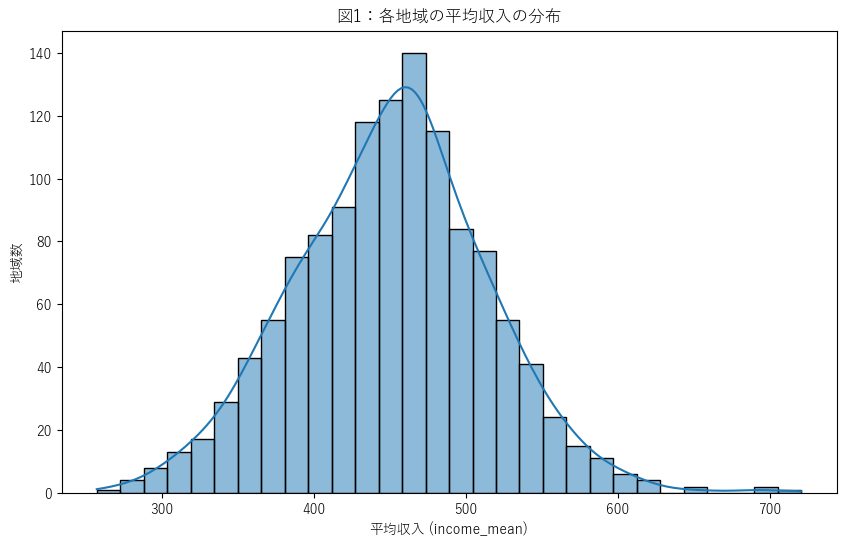

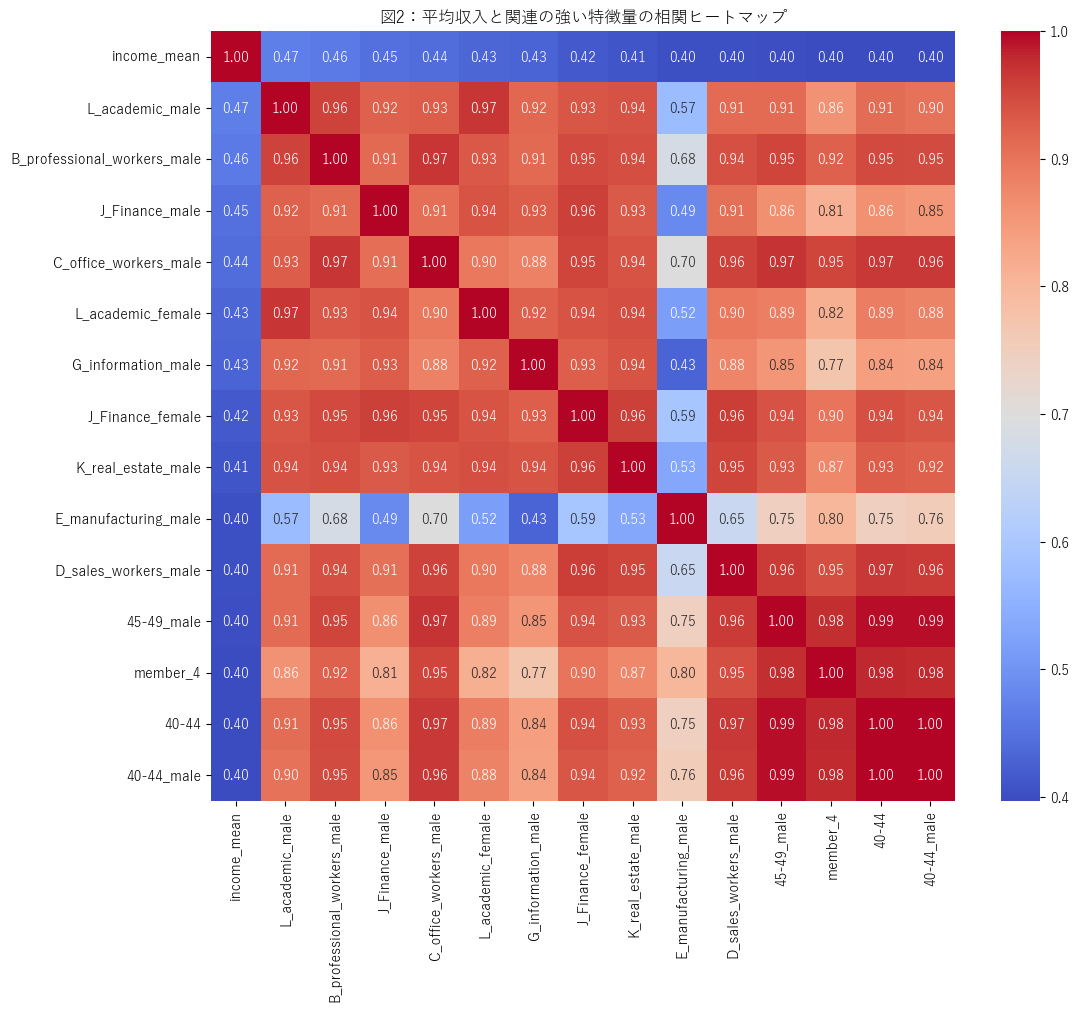

In [15]:
plt.rcParams['font.family'] = 'Yu Gothic'

# --- 可視化1：目的変数「平均収入」の分布を確認 ---
plt.figure(figsize=(10, 6))
sns.histplot(all_df['income_mean'], kde=True, bins=30)
plt.title('図1：各地域の平均収入の分布')
plt.xlabel('平均収入 (income_mean)')
plt.ylabel('地域数')
print("平均収入の基本統計量:")
print(all_df['income_mean'].describe())


# --- 可視化2：どの特徴量が収入と関係が深いか---
# 相関係数を計算
correlation_matrix = all_df.corr()

# 平均収入との相関が高い上位15個の特徴量を取得
top_features = correlation_matrix.nlargest(15, 'income_mean')['income_mean'].index
top_corr_matrix = all_df[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('図2：平均収入と関連の強い特徴量の相関ヒートマップ')

# グラフを表示
plt.show()

In [ ]:
# モデル構築に必要なライブラリをインポート
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# --- 欠損値の処理 ---
# 予測したいターゲットである 'income_mean' に欠損値(NaN)が含まれていると学習できないため事前に削除。
df_for_model = all_df.dropna(subset=['income_mean'])
print(f"収入データのない地域を除外し、{len(df_for_model)} 件のデータでモデルを構築します。")


# --- 1．特徴量TOP5を用いたモデル ---
# 特徴量を選ぶ：ヒートマップで確認した、収入との相関が最も高い5つの特徴量を使用
# (6を指定してincome_mean自身を除外することで、TOP5つを取得)
top_5_features = correlation_matrix.nlargest(6, 'income_mean').index.drop('income_mean')
print(f"使用する特徴量 (TOP5): {top_5_features.tolist()}")

# データを特徴量(X)とターゲット(y)に分割
X1 = df_for_model[top_5_features]
y1 = df_for_model['income_mean']

# 訓練データとテストデータに分割 (80%を訓練用、20%を評価用)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# モデルを定義して学習
model1 = RandomForestRegressor(random_state=42, n_estimators=100)
model1.fit(X1_train, y1_train)

# テストデータで予測と評価
y1_pred = model1.predict(X1_test)
r2_1 = r2_score(y1_test, y1_pred)
rmse_1 = np.sqrt(mean_squared_error(y1_test, y1_pred))

print(f"【結果】R²スコア: {r2_1:.3f}, RMSE: {rmse_1:.3f}")

収入データのない地域を除外し、1238 件のデータでモデルを構築します。
使用する特徴量 (TOP5): ['L_academic_male', 'B_professional_workers_male', 'J_Finance_male', 'C_office_workers_male', 'L_academic_female']
【結果】R²スコア: 0.317, RMSE: 51.504


初期モデルの評価
	初期モデルでは、R²スコアが 0.317 となった。これは、このモデルが地域ごとの平均収入のばらつきの約31.7%を説明できていることを意味する。一定の予測能力は示されているものの、まだ多くの情報を見逃している状態と言える。RMSE（予測誤差の平均）が約51.6万円であることから、個々の地域の収入予測にはまだ大きな誤差が含まれている。

精度の改善策
	①特徴量の追加: 
		現在は190以上ある特徴量の中から5つしか使用していない。ヒートマップで確認したように、収入と相関のある特徴量は他にも多く存在する。これらの情報をモデルに追加することで、より多角的な視点から収入を予測できるようになり、精度向上が期待できる。
	②特徴量エンジニアリング: 
		既存のデータから、より予測に有効な新しい特徴量を作成する。例えば、「総人口」に対する「特定の職業の就業者数」の割合を計算することで、単純な人数よりも地域の特色を強く反映した特徴量を作れる可能性がある。
	③ハイパーパラメータチューニング: 
		現在モデルはデフォルトの設定で動作しているが、RandomForestRegressorが持つ内部パラメータを最適化することで、モデルの性能をさらに上げられるのではないか。

In [ ]:
#改善策①を実行
# --- 2．特徴量TOP15に増やした改善モデル ---
# 特徴量を増やす：相関が高いTOP15個の特徴量を使用
top_15_features = correlation_matrix.nlargest(16, 'income_mean').index.drop('income_mean')
print(f"使用する特徴量 (TOP15): {top_15_features.tolist()}")

# データを特徴量(X)とターゲット(y)に分割
X2 = df_for_model[top_15_features]
y2 = df_for_model['income_mean']

# 訓練データとテストデータに分割
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# モデルを定義して学習
model2 = RandomForestRegressor(random_state=42, n_estimators=100)
model2.fit(X2_train, y2_train)

# テストデータで予測と評価
y2_pred = model2.predict(X2_test)
r2_2 = r2_score(y2_test, y2_pred)
rmse_2 = np.sqrt(mean_squared_error(y2_test, y2_pred))

print(f"【結果】R²スコア: {r2_2:.3f}, RMSE: {rmse_2:.3f}")

使用する特徴量 (TOP15): ['L_academic_male', 'B_professional_workers_male', 'J_Finance_male', 'C_office_workers_male', 'L_academic_female', 'G_information_male', 'J_Finance_female', 'K_real_estate_male', 'E_manufacturing_male', 'D_sales_workers_male', '45-49_male', 'member_4', '40-44', '40-44_male', 'K_real_estate_female']
【結果】R²スコア: 0.590, RMSE: 39.926


改善モデルの評価：
	使用する特徴量を上位5個から上位15個に増やしたところ、R²スコアは 0.317 → 0.590 へと大幅に向上し、RMSEも 51.6万円 → 39.9万円 へと大きく減少した。

	この精度向上の主な要因は、モデルが利用できる情報量が格段に増えたことにある。初期モデルは5つの視点からしか地域を評価できなかったが、改善モデルは15の多様な視点から地域を総合的に分析できるようになった。

	新たに追加された10個の特徴量は、単体での相関はTOP5に劣るものの、TOP5の特徴量だけでは捉えきれなかった別の側面からの情報（例えば、特定の年齢層の人口や、異なる産業の労働者数など）を提供しする。RandomForestRegressorは、これらの複数の特徴量間の複雑な関係性を学習する能力に長けているため、より豊かで多角的な情報を与えられたことで、より現実に即した精度の高い予測が可能になったと考えられる。

さらに精度を上げるためには、より多くの特徴量から最適な組み合わせを探すことが考えられる。今回は挑戦できなかったが、今後は特徴量エンジニアリングや、ハイパーパラメータチューニングといった、より高度な手法も勉強して取り組んでいきたい。